### LANL Earthquake Prediction check using SVR, Kernel ridge, KNN and XGboost

Importing relevant libraries

In [1]:
#data visulalization
import matplotlib.pyplot as plt

#data preprocessing
import pandas as pd

#math operations
import numpy as np

#hyperparameter optimization
import scipy.stats as stats

#hyperparameter optimization
from sklearn.model_selection import GridSearchCV

#XGboost regressor
from xgboost import XGBRegressor as xgbr

#KNN
from sklearn import neighbors

#SVR
from sklearn.svm import SVR

#Kernel Ridge
from sklearn.kernel_ridge import KernelRidge

#principal component analysis
from sklearn.decomposition import PCA

#Mean absolute error
from sklearn.metrics import mean_absolute_error

#Splitting data into testing and validation set
from sklearn.model_selection import train_test_split

Importing data from CSV as dataframe

In [2]:
train = pd.read_csv('train.csv', dtype={'acoustic_data': np.int16, 'time_to_failure': np.float64})
print(train.shape)
train.head(10)

(629145480, 2)


,acoustic_data,time_to_failure
0,12,1.4691
1,6,1.4691
2,8,1.4691
3,5,1.4691
4,8,1.4691
5,8,1.4691
6,9,1.4691
7,7,1.4691
8,-5,1.4691
9,3,1.4691


Data visualization 1% of samples data, first 100 datapoints

(6291455,)


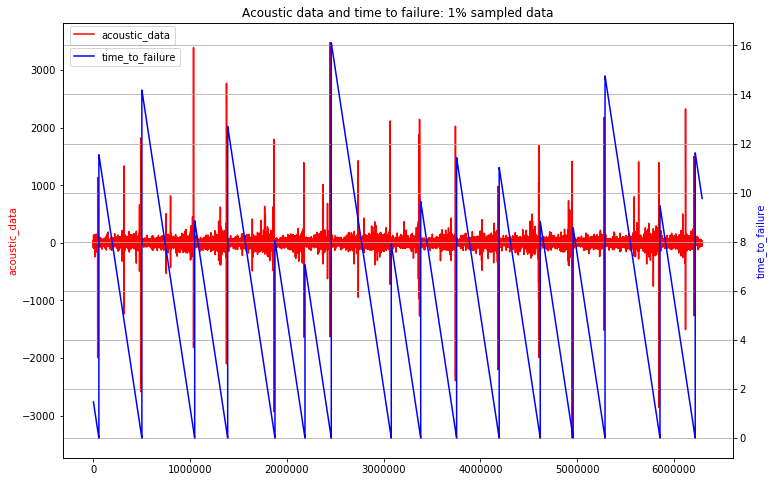

In [3]:
train_ad_sample_df = train['acoustic_data'].values[::100]
train_ttf_sample_df = train['time_to_failure'].values[::100]
print(train_ad_sample_df.shape)

def plot_acc_ttf_data(train_ad_sample_df, train_ttf_sample_df, title="Acoustic data and time to failure: 1% sampled data"):
    fig, ax1 = plt.subplots(figsize=(12, 8))
    plt.title(title)
    plt.plot(train_ad_sample_df, color='r')
    ax1.set_ylabel('acoustic_data', color = 'r')
    plt.legend(['acoustic_data'], loc=(0.01,0.95))
    ax2=ax1.twinx()
    plt.plot(train_ttf_sample_df, color='b')
    ax2.set_ylabel('time_to_failure', color = 'b')
    plt.legend(['time_to_failure'], loc = (0.01,0.9))
    plt.grid(True)

plot_acc_ttf_data(train_ad_sample_df, train_ttf_sample_df)
del train_ad_sample_df
del train_ttf_sample_df

Note:
-> Not all spikes are not followed by earthquake. 
-> Earthquake data is limited to very small data points.
-> Vibration pattern can give information on prediction.

Scaling factors

In [4]:
delta_X = train['acoustic_data'].max()-train['acoustic_data'].min()
delta = (train['time_to_failure'].max()-train['time_to_failure'].min())
print(delta_X, delta)

10959 16.107304496036832


Getting the statistics of data

In [5]:
rand_idxs = np.random.randint(0, 629145480-150000, size=16384, dtype=np.int32)
def sample_statistics(X_EQ):
    X_statistics=np.array([])
    X_statistics=np.append(X_statistics,X_EQ.mean())
    X_statistics=np.append(X_statistics,X_EQ.std())
    X_statistics=np.append(X_statistics,X_EQ.min())
    X_statistics=np.append(X_statistics,X_EQ.max())
    X_statistics=np.append(X_statistics,stats.kurtosis(X_EQ))
    X_statistics=np.append(X_statistics,stats.skew(X_EQ))
    X_statistics=np.append(X_statistics,np.quantile(X_EQ,[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]))

    return X_statistics

Breaking data into chunks and getting statistics 

In [6]:
X = np.array([])
y = np.array([])
for st_idx in rand_idxs:
    X=np.append(X,sample_statistics(train['acoustic_data'].values[st_idx: st_idx + 150000]))
    y=np.append(y,pd.Series(train['time_to_failure'].values[st_idx: st_idx + 150000][-1]).to_numpy())
del train
y = np.asarray(y)
X = np.asarray(X).reshape(16384,15)/delta_X
y.reshape(len(y),)

array([10.47889713,  3.07669708, 15.06679572, ...,  6.95159903,
       16.05099768,  4.7160972 ])

Training and validation split

In [7]:
X_train, X_test = train_test_split(X, test_size = 0.1, random_state=42)
y_train, y_test = train_test_split(y, test_size = 0.1, random_state=42)

pca = PCA(8)
pca.fit(X)

X = pca.transform(X)

X_train_pca, X_test_pca = train_test_split(X, test_size = 0.1, random_state=42)
y_train_pca, y_test_pca = train_test_split(y, test_size = 0.1, random_state=42)

del X,y

PCA parameters components

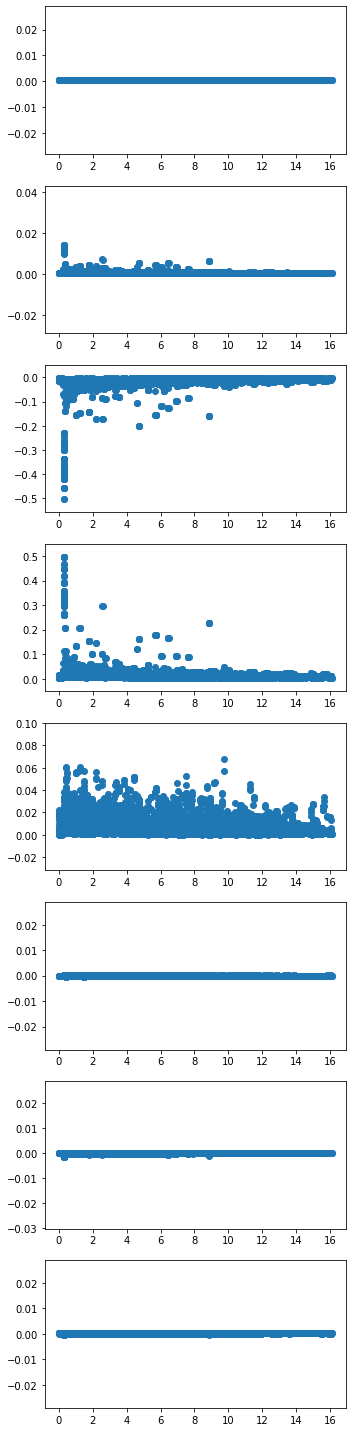

In [8]:
fig, ax = plt.subplots(8, 1, figsize=(5,20))

for i in range(8):
    ax[i].scatter(y_train, X_train[:,i])

plt.tight_layout()
plt.show()

SVR and Kernal Ridge fitting

In [9]:
#SVR parameter optimization
svr = GridSearchCV(SVR(kernel='rbf', gamma=0.1), param_grid={"C": np.arange(6.5, 7.5,0.5), "gamma": np.logspace(6.5, 7.5, 3)})
svr.fit(X_train, y_train)
y_svr = svr.predict(X_test)
print(svr.best_score_, svr.best_params_)

#Kernal ridge parameter optimization
kr = GridSearchCV(KernelRidge(kernel='rbf', gamma=0.1), param_grid={"alpha": np.arange(0.002,0.003,0.0002), "gamma": np.logspace(4, 5, 5)})
kr.fit(X_train, y_train)
y_kr = kr.predict(X_test)
print(kr.best_score_, kr.best_params_)

0.54706678019587 {'C': 7.0, 'gamma': 10000000.0}
0.4907237489110484 {'alpha': 0.0028000000000000004, 'gamma': 100000.0}


SVR MAE: 1.418367578496569
Kernel ridge: 1.8315844466752784


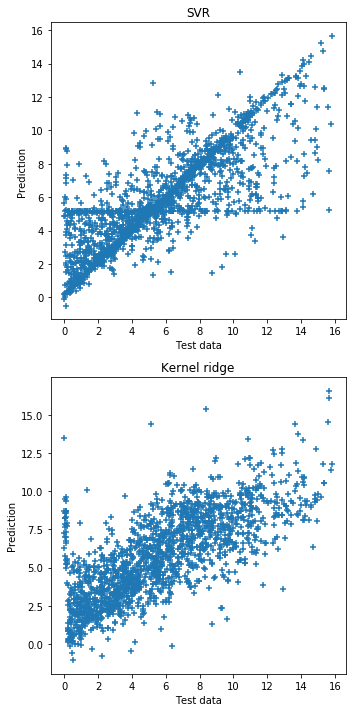

In [15]:
fig, ax = plt.subplots(2, 1, figsize=(5,10))

ax[0].scatter(y_test, y_svr, marker='+')
ax[0].set(title="SVR", xlabel='Test data', ylabel='Prediction')
print("SVR MAE:",mean_absolute_error(y_test, y_svr))

ax[1].scatter(y_test, y_kr, marker='+')
ax[1].set(title="Kernel ridge", xlabel='Test data', ylabel='Prediction')
print("Kernel ridge:",mean_absolute_error(y_test, y_kr))

plt.tight_layout()
plt.show()

In [10]:
print("SVR MAE:",mean_absolute_error(y_test, y_svr))
print("Kernel ridge MAE:",mean_absolute_error(y_test, y_kr))

SVR MAE: 1.418367578496569
Kernel ridge MAE 1.8315844466752784


KNN fitting

0.5291302970059272 {'n_neighbors': 2}
KNN MAE: 1.3682635741049385
0.6123534283011773 {'n_neighbors': 5}
KNN MAE: 1.3131906468265395


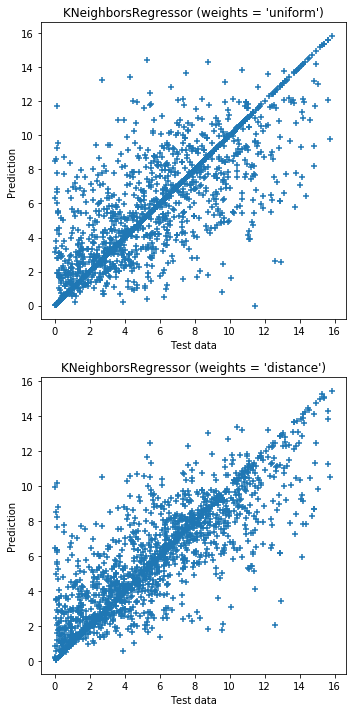

In [17]:
fig, ax = plt.subplots(2, 1, figsize=(5,10))

for i, weights in enumerate(['uniform', 'distance']):
    knn = GridSearchCV(neighbors.KNeighborsRegressor(weights=weights), param_grid={"n_neighbors": [1,2,3,4,5,6,7,8,9]})
    y_pred = knn.fit(X_train, y_train).predict(X_test)
    print(knn.best_score_, knn.best_params_)

    ax[i].scatter(y_test, y_pred, marker='+')
    ax[i].set(title="KNeighborsRegressor (weights = '%s')" % (weights), xlabel='Test data', ylabel='Prediction')
    err=mean_absolute_error(y_test, y_pred)
    print("KNN MAE:",err)

plt.tight_layout()
plt.show()

XGBoost Regression

In [19]:
model = xgbr(colsample_bytree=0.2, gamma=0.0,
             learning_rate=0.05, max_depth=50,
             min_child_weight=1.5, n_estimators=7200,
             reg_alpha=0.9, reg_lambda=0.6,
             subsample=0.2, seed=0, silent=1,
             random_state=7)

model.fit(X_train, y_train)

xgb_valid = model.predict(X_test)
xgbr_error = mean_absolute_error(y_test, xgb_valid)
print("mean absolute error", xgbr_error)

mean absolute error 1.5947683517700288


Validation error

In [20]:
print(xgb_valid)

[14.930405   2.6370006  7.7423964 ...  5.624096  10.635931   5.6918817]


Text(0, 0.5, 'Test data')

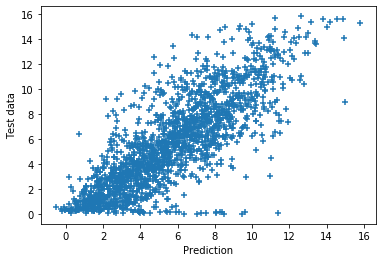

In [23]:
plt.scatter(xgb_valid,y_test, marker='+')
plt.xlabel("Prediction")
plt.ylabel("Test data")

Test data

In [24]:
import os
ld = os.listdir("test")
type(ld)
test_list=[]
for strin in ld:
    if 'seg' in strin:
        test_list.append(strin)

In [25]:
X_test_1 = []
for test_ex1 in test_list:
    test_data1=sample_statistics(pd.read_csv("test/"+test_ex1, dtype={'acoustic_data': np.int16}).values)
    X_test_1.append(test_data1)

In [26]:
X_test_1 = np.asarray(X_test_1).reshape(2624,15)/delta_X
prediction = model.predict(X_test_1)

In [27]:
test_list=np.char.replace(np.asarray(test_list), ".csv", "")
forecast = pd.DataFrame(columns=['seg_id', 'time_to_failure'])
forecast['seg_id'] = test_list
forecast['time_to_failure'] = prediction
print(forecast)
forecast.to_csv("submission.csv", index = False, sep=',', encoding='utf-8')

          seg_id  time_to_failure
0     seg_00030f         4.022451
1     seg_0012b5         5.746650
2     seg_00184e         9.016999
3     seg_003339         8.783433
4     seg_0042cc         5.782279
...          ...              ...
2619  seg_ff4236         3.525967
2620  seg_ff7478         5.613388
2621  seg_ff79d9         2.880025
2622  seg_ffbd6a         2.218293
2623  seg_ffe7cc         8.422976

[2624 rows x 2 columns]
